## Imports

In [64]:
import pandas as pd
import numpy as np

df_AA2024 = pd.read_excel('/workspaces/project-project-surface-science-syndicate/data/averaged_filtered_AA2024.xlsx')
print(df_AA2024.describe())

           Time_h          pH  Inhib_Concentrat_M  Salt_Concentrat_M  \
count  515.000000  515.000000          515.000000         515.000000   
mean   157.151456    6.613592            0.006934           0.113476   
std    212.312862    2.270734            0.012923           0.159137   
min      0.500000    0.000000            0.000010           0.000000   
25%     24.000000    4.400000            0.001000           0.050000   
50%     24.000000    7.000000            0.001000           0.100000   
75%    240.000000    7.000000            0.003000           0.100000   
max    672.000000   10.000000            0.100000           0.600000   

        Efficiency  
count   515.000000  
mean     18.439395  
std     313.671188  
min   -4834.000000  
25%      25.625000  
50%      50.000000  
75%      85.475000  
max     100.000000  


In [65]:
print(df_AA2024.head())

                                  SMILES  Time_h    pH  Inhib_Concentrat_M  \
0                   C(=O)(C(=O)[O-])[O-]    24.0   4.0              0.0010   
1                   C(=O)(C(=O)[O-])[O-]    24.0   7.0              0.0005   
2                   C(=O)(C(=O)[O-])[O-]    24.0  10.0              0.0010   
3  C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O    24.0   4.0              0.0010   
4  C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O    24.0   7.0              0.0005   

   Salt_Concentrat_M  Efficiency  
0               0.10       20.00  
1               0.05       12.35  
2               0.10       20.00  
3               0.10       30.00  
4               0.05      -23.95  


In [66]:
df_AA1000 = pd.read_excel('/workspaces/project-project-surface-science-syndicate/data/averaged_filtered_AA1000.xlsx')
print(df_AA1000.describe())

           Time_h          pH  Inhib_Concentrat_M  Salt_Concentrat_M  \
count  308.000000  308.000000        3.080000e+02         308.000000   
mean    51.396104    0.487604        3.254313e-03           0.055195   
std     89.903328    1.982179        8.760655e-03           0.312923   
min      0.000000   -0.600000        1.000000e-07           0.000000   
25%      1.500000    0.000000        1.958864e-04           0.000000   
50%      3.500000    0.000000        1.200000e-03           0.000000   
75%     48.000000    1.000000        3.200000e-03           0.000000   
max    384.000000   13.000000        1.000000e-01           2.000000   

       Efficiency  
count  308.000000  
mean    62.410191  
std     22.171607  
min    -49.170000  
25%     51.793750  
50%     67.030000  
75%     78.000000  
max     96.200000  


Construct dataframe to work with

In [67]:
df = df_AA1000

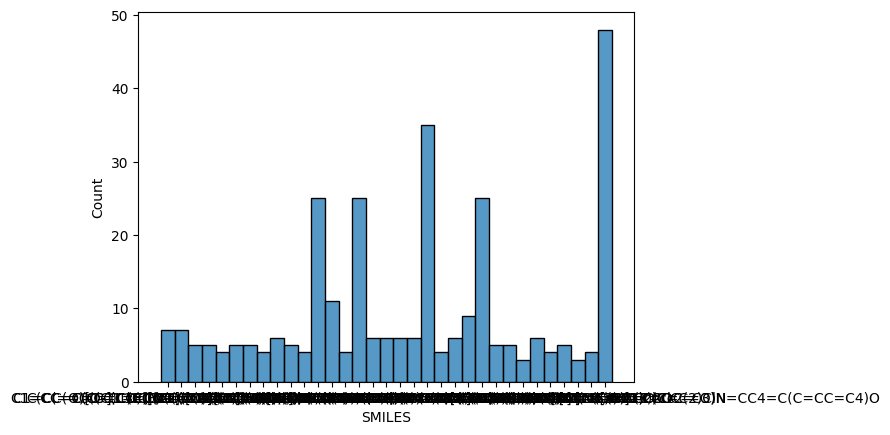

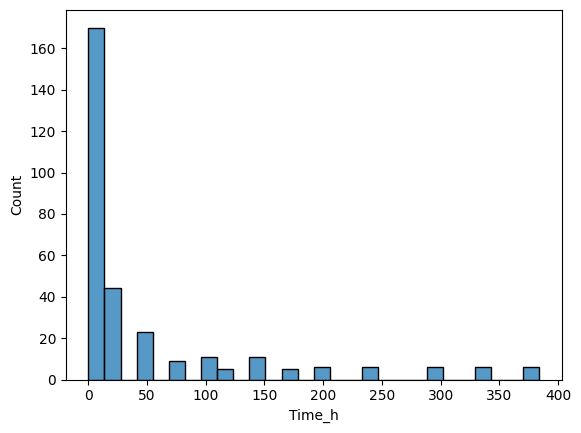

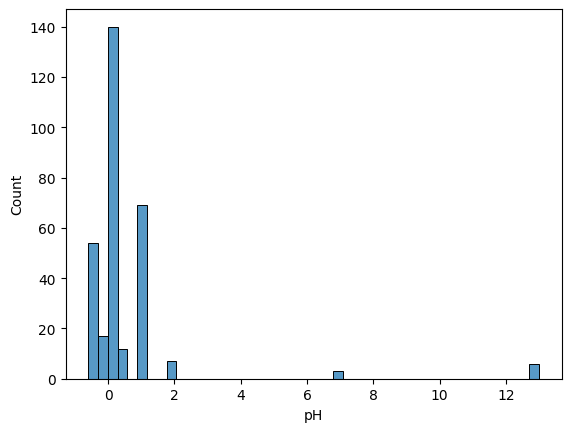

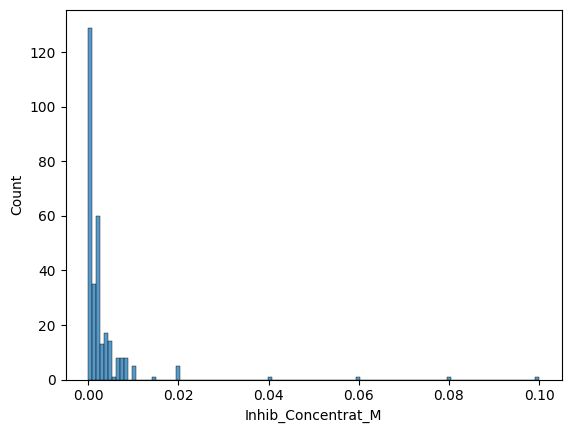

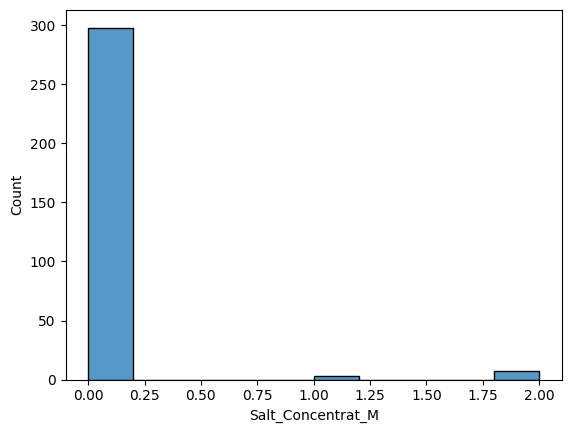

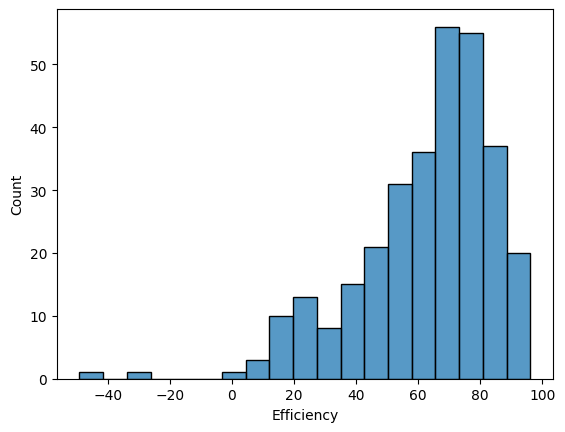

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns

for i, column in enumerate(df.columns, 1):
    sns.histplot(df[column])
    plt.show()

### Set targets/objectives = efficiency for now

In [69]:
from baybe.targets import NumericalTarget
from baybe.objective import Objective

target = NumericalTarget(
    name="Efficiency",
    mode="MAX",
)
objective = Objective(mode="SINGLE", targets=[target])

### Search Space

In [70]:
from baybe.parameters import NumericalContinuousParameter, CategoricalParameter, NumericalDiscreteParameter
from baybe.searchspace import SearchSpace

basic_parameters=[
NumericalDiscreteParameter(
    name="Time_h",
    values=df["Time_h"].unique(),
    tolerance=5/60,
),
NumericalDiscreteParameter(
    name="pH",
    values=df["pH"].unique(),
    ),  
NumericalDiscreteParameter(
    name="Inhib_Concentrat_M",
    values=df["Inhib_Concentrat_M"].unique(),
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df["Salt_Concentrat_M"].unique(),
    ),
]

**Substance parameter**

Instead of values, this parameter accepts data in form of a dictionary. The items correspond to pairs of labels and SMILES. SMILES are string-based representations of molecular structures. Based on these, BayBE can assign each label a set of molecular descriptors as encoding.

In [71]:
#Create a dictionary of unique SMILES representations found in the dataframe

unique_SMILES = df["SMILES"].unique()

dic_SMILES = dict(zip(unique_SMILES, unique_SMILES))

print(dic_SMILES)

{'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O': 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O', 'C(C(CO)([N+](=O)[O-])Br)O': 'C(C(CO)([N+](=O)[O-])Br)O', 'C(CC=O)CC=O': 'C(CC=O)CC=O', 'C1=CC(=C(C=C1F)F)C(CN2C=NC=N2)(CN3C=NC=N3)O': 'C1=CC(=C(C=C1F)F)C(CN2C=NC=N2)(CN3C=NC=N3)O', 'C1=CC(=CN=C1)C=NNC(=S)N': 'C1=CC(=CN=C1)C=NNC(=S)N', 'C1=CC(=NC(=C1)N)N': 'C1=CC(=NC(=C1)N)N', 'C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=CN=C4': 'C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=CN=C4', 'C1=CC=NC(=C1)C=NNC(=S)N': 'C1=CC=NC(=C1)C=NNC(=S)N', 'C1=CN=C(C=N1)C(=O)N': 'C1=CN=C(C=N1)C(=O)N', 'C1=CN=C(N=C1)N': 'C1=CN=C(N=C1)N', 'C1=CN=CC=C1C=NNC(=S)N': 'C1=CN=CC=C1C=NNC(=S)N', 'C1CCC(=NO)CC1': 'C1CCC(=NO)CC1', 'C1N2CN3CN1CN(C2)C3': 'C1N2CN3CN1CN(C2)C3', 'C=CC1=C(N2C(C(C2=O)NC(=O)C(=NOCC(=O)O)C3=CSC(=N3)N)SC1)C(=O)O': 'C=CC1=C(N2C(C(C2=O)NC(=O)C(=NOCC(=O)O)C3=CSC(=N3)N)SC1)C(=O)O', 'CC(=NO)C': 'CC(=NO)C', 'CC(C)(C)NCC(COC1=CC=CC2=C1CC(C(C2)O)O)O': 'CC(C)(C)NCC(COC1=CC=CC2=C1CC(C(C2)O)O)O', 'CC(C)(C)NCC(COC1=NSN=C1N

In [72]:
from baybe.parameters import SubstanceParameter

mordred_parameters = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=dic_SMILES,
        encoding="MORDRED",
    )
]

rdkit_parameters = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=dic_SMILES,
        encoding="RDKIT",
    )
]

morganfp_parameters = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=dic_SMILES,
        encoding="MORGAN_FP",
    )
]

ohe_parameters = basic_parameters + [
    CategoricalParameter(
        name="SMILES",
        values=unique_SMILES,
        encoding="OHE",
    )
]

# Access the base class to generate a substance parameter with one-hot encoding
from baybe.parameters.enum import ParameterEncoding

substance_parameter_OHE = SubstanceParameter(
    name="SMILES",
    data=dic_SMILES,
)

substance_parameter_OHE.encoding = ParameterEncoding.OHE

ohe_parameters = basic_parameters + [substance_parameter_OHE]


In [73]:
searchspace_mordred = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), mordred_parameters)
searchspace_rdkit = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), rdkit_parameters)
searchspace_morganfp = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), morganfp_parameters)
searchspace_ohe = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), ohe_parameters)

### Recommenders

The **SequentialGreedyRecommender** is a powerful recommender that leverages BoTorch optimization functions to perform sequential Greedy optimization. It can be applied for discrete, continuous and hybrid sarch spaces. It is an implementation of the BoTorch optimization functions for discrete, continuous and mixed spaces. **It is important to note that this recommender performs a brute-force search when applied in hybrid search spaces, as it optimizes the continuous part of the space while exhaustively searching choices in the discrete subspace.** You can customize this behavior to only sample a certain percentage of the discrete subspace via the sample_percentage attribute and to choose different sampling strategies via the hybrid_sampler attribute. 

e.g.
strategy = TwoPhaseStrategy(recommender=SequentialGreedyRecommender(hybrid_sampler="Farthest", sampling_percentage=0.3))

For implementing fully customized surrogate models e.g. from sklearn or PyTorch, see:
https://emdgroup.github.io/baybe/examples/Custom_Surrogates/Custom_Surrogates.html


In [74]:
from baybe.recommenders import (
    SequentialGreedyRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
)

recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=SequentialGreedyRecommender(),  # Bayesian model-based optimization
)

### Campaign Strategy

In [75]:
from baybe.strategies import TwoPhaseStrategy
from baybe import Campaign

campaign_rdkit = Campaign(searchspace_rdkit, objective)
campaign_mordred = Campaign(searchspace_mordred, objective)
campaign_morganfp = Campaign(searchspace_morganfp, objective)
campaign_ohe = Campaign(searchspace_ohe, objective)

### Start simulation

In [76]:
scenarios = {
    "RDKIT" : campaign_rdkit,
    "MORDRED" : campaign_mordred,
    "MORGAN FP" : campaign_morganfp,
    "OHE" : campaign_ohe,
}

In [77]:
from baybe.simulation import simulate_scenarios

N_MC_ITERATIONS = 10
N_DOE_ITERATIONS = 50
BATCH_SIZE = 1

results = simulate_scenarios(
    scenarios,
    df,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/40 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


  2%|2         | 1/40 [00:07<04:33,  7.00s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
  5%|5         | 2/40 [00:15<05:03,  7.98s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction fac

FileNotFoundError: [Errno 2] No such file or directory: 'Scenarios.pdf'

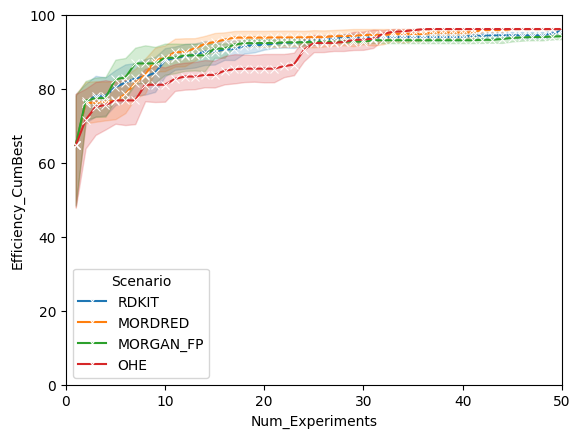

In [83]:
sns.lineplot(
    data=results,
    x="Num_Experiments",
    y="Efficiency_CumBest",
    hue="Scenario",
    marker="x",
)

plt.xlim(0, N_DOE_ITERATIONS)
plt.ylim(0, 100)

plt.savefig("Scenarios")

# Evalute best results

In [79]:
print(results.columns)

Index(['Scenario', 'Random_Seed', 'Iteration', 'Num_Experiments',
       'Efficiency_Measurements', 'Efficiency_IterBest', 'Efficiency_CumBest'],
      dtype='object')
